In [378]:
import numpy as np
import scipy.optimize
import scipy.interpolate as interp
import sys
from scipy import signal
from lmfit import minimize, Parameters
from multiprocessing import Process

from matplotlib.pyplot import *
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['mathtext.fontset'] = 'dejavuserif'

#Make np arrays print in scientific notation:
np.set_printoptions(formatter={'float': lambda x: format(x, '9.4E')})
#Make numbers display in exponential form:
%precision %e

u'%e'

In [2]:
'''#Create the ability to customize axis label formats
def log_10_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    return '%.3f' % (x)
formatter = FuncFormatter(log_10_product)
'''
end=1

In [3]:
#Importing halo mass array from the Bolshoi simulation
MHALDATA = np.loadtxt ("halo_bolshoi_z0.00_D360.dat", unpack=True, usecols=1) #halo mass per 250/0.7 cubic megaparsecs

# Hudson's $f_*(M_h)$ function
The following cell defines Hudson's fitting function and starts the code off with some guesses as to the parameters thereof.

In [145]:
#Defining Hudson's fstar function
def fstar(m_indp,m1,f1,beta,gamma,*params):
    '''The following few lines give the user the option to push either a value 
    or the f1 function with associated parameters to the fstar function'''
    if callable(f1):
        f1val=f1(*params[:3])
    else:
        f1val=f1
    '''The following few lines give the user the option to push either a value 
    or the m1 function with associated parameters to the fstar function'''
    if callable(m1):
        m1val=m1(*params[3:])
    else:
        m1val=m1
    fstar=2.*f1val*((m_indp/m1val)**-beta
                               +(m_indp/m1val)**gamma)**-1.
    return fstar

'''Hudson allows f1, the stellar fraction at a given mass, and m1, a 
characteristic halo mass, to evolve with 
redshift, the method of which the following functions reproduce.'''
def f1(fpoint5,z,fz):
    f1=fpoint5+(z-0.5)*fz
    return f1
def m1(logmpoint5,z,mz):
    logm1=logmpoint5+(z-0.5)*mz
    m1=10.**logm1
    return m1

#Redshift
z=0

#f1 inputs
fpoint5_0=0.0414
fz_0=0.029
f1_0=0.022 #This is the value I'll use to override f1 instead of using the f1 function, when I choose to do so.

#m1 inputs
logmpoint5_0=11.04
mz_0=0.56
m1_0=10.**12.
logm1_0=np.log10(m1_0)

#Other fstar inputs
beta_0=1.28
gamma_0=0.73

p0=[logm1_0,f1_0,beta_0,gamma_0]

p0_Parameters=Parameters()
p0_Parameters.add('logm1',value=logm1_0)
p0_Parameters.add('f1',value=f1_0)
p0_Parameters.add('beta',value=beta_0)
p0_Parameters.add('gamma',value=gamma_0)

# Using Bolshoi halo masses
The following cell populates $f_*$ with the halo masses that appear in the Bolshoi simulation.

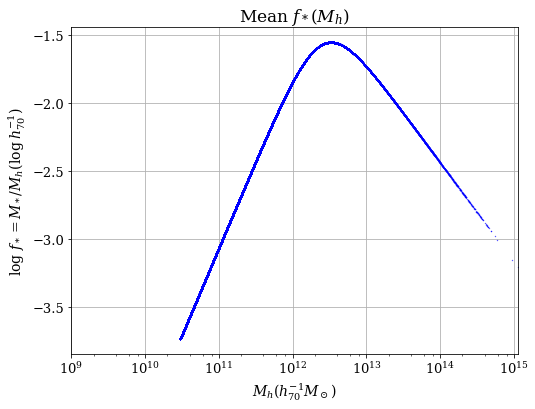

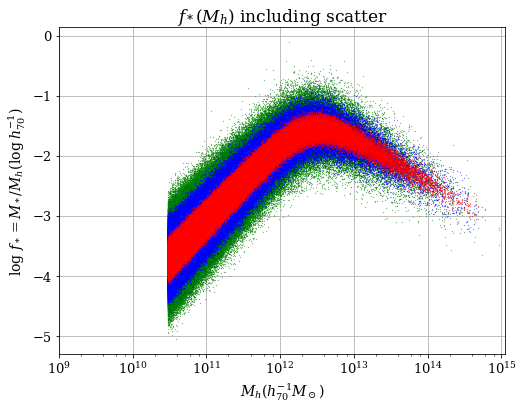

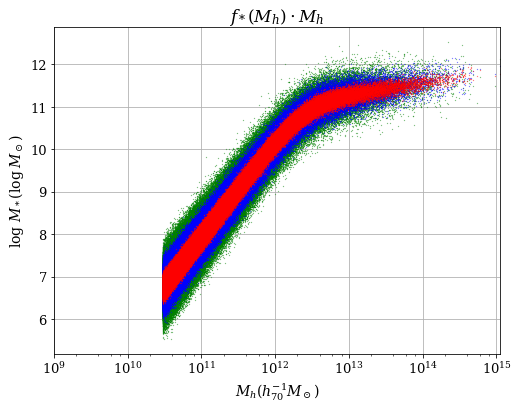

In [132]:
fstarofmhal=fstar(MHALDATA,m1_0,f1,beta_0,gamma_0,fpoint5_0,z,fz_0) #This would be the line to use to push the m1 function as opposed to a forced value for m1
#fstarofmhal=fstar(mhal,10.**12,f1,beta_0,gamma_0,fpoint5_0,z,fz_0,logmpoint5_0,z,mz_0) #Using this to force a value into m1 as opposed to using the m1 function with associated parameters

logfstarofmhal=np.log10(fstarofmhal) #Put f_*(M_h) in log

#Adding different scatters to log f_*
GAUSSN=MHALDATA.size
GAUSS1=np.random.normal(0,0.1,GAUSSN) #create an array of Gaussian random deviates with std dev 0.1
GAUSS2=np.random.normal(0,0.2,GAUSSN) #create an array of Gaussian random deviates with std dev 0.2
GAUSS3=np.random.normal(0,0.3,GAUSSN) #create an array of Gaussian random deviates with std dev 0.3
logfstarofmhalprime1=GAUSS1+logfstarofmhal 
logfstarofmhalprime2=GAUSS2+logfstarofmhal 
logfstarofmhalprime3=GAUSS3+logfstarofmhal 

#Defining M_* based on Bolshoi halo masses, as distinct from f_*(M_*/M_h)
logmstarofmhalprime1=logfstarofmhalprime1+np.log10(MHALDATA)
logmstarofmhalprime2=logfstarofmhalprime2+np.log10(MHALDATA)
logmstarofmhalprime3=logfstarofmhalprime3+np.log10(MHALDATA)

#Plotting Hudson's f_* using Bolshoi halo masses############################
plotbase=10 #The plots below will use a log scale for their y axes with base plotbase
xmin=10.**9.
xmax=max(MHALDATA)

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(1,1,1)
ax.semilogx(MHALDATA,logfstarofmhal,'bo',markersize=0.3)
ax.set_xlim(xmin,xmax)
ax.set_title('Mean $f_*(M_h)$',fontsize=17)
ax.set_ylabel('log $f_*=M_*/M_h(\log\;h^{-1}_{70})$',fontsize=14)
ax.set_xlabel('$M_h(h_{70}^{-1}M_\odot)$',fontsize=14)
ax.tick_params(axis='both',labelsize=13)
ax.grid(True)
plt.show()
############################################################################

#Plotting Hudson's f_* using Bolshoi halo masses with scatter added#########
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(1,1,1)
ax.semilogx(MHALDATA,logfstarofmhalprime3,'go',markersize=0.2)
ax.semilogx(MHALDATA,logfstarofmhalprime2,'bo',markersize=0.2)
ax.semilogx(MHALDATA,logfstarofmhalprime1,'ro',markersize=0.2)
ax.set_xlim(xmin,xmax)
ax.set_title('$f_*(M_h)$ including scatter',fontsize=17)
ax.set_ylabel('log $f_*=M_*/M_h(\log\;h^{-1}_{70})$',fontsize=14)
ax.set_xlabel('$M_h(h_{70}^{-1}M_\odot)$',fontsize=14)
ax.tick_params(axis='both',labelsize=13)
ax.grid(True)
plt.show()
############################################################################

#Showing just M_* based on Bolshoi masses, not M_*/M_h######################
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(1,1,1)
ax.semilogx(MHALDATA,logmstarofmhalprime3,'go',markersize=0.2)
ax.semilogx(MHALDATA,logmstarofmhalprime2,'bo',markersize=0.2)
ax.semilogx(MHALDATA,logmstarofmhalprime1,'ro',markersize=0.2)
ax.set_xlim(xmin,xmax)
ax.set_title('$f_*(M_h)\cdot M_h$',fontsize=17)
ax.set_ylabel('log $M_*(\log\;M_\odot)$',fontsize=14)
ax.set_xlabel('$M_h(h_{70}^{-1}M_\odot)$',fontsize=14)
ax.tick_params(axis='both',labelsize=13)
ax.grid(True)
plt.show()
############################################################################

# Optimization
The next cell does the following.<br>
1) Defines the indipendent variable array (log stellar masses)<br>
2) Defines and calculates the Baldy SMF function. This is the curve we are trying to match for various values of scatter by fitting a set of $f_*$ parameters for each of those scatter values.<br>
3) Attempts to find the parameters of the Hudson fitting function for which the resulting stellar mass function matches Baldry.

In [363]:
#CREATING BINS######################################################################
LOGMSTARBINSIZE=0.05 #Bin size in units of dex
BEGBINS=8.
ENDBINS=11.4
LOGMSTARBINS=np.arange(BEGBINS,ENDBINS+LOGMSTARBINSIZE,LOGMSTARBINSIZE) #M_* bins in dex (Add 1 to the num arg because the elements include the starting point.)
LOGMSTARMIDBINS=(LOGMSTARBINS[1:]+LOGMSTARBINS[:-1])/2
####################################################################################

#Defining the SMF by Baldy et. al. 2012#############################################
def smf(m,m_ast,phi_ast1,phi_ast2,alpha1,alpha2):
    return np.exp(-m/m_ast)*(phi_ast1*(m/m_ast)**alpha1+phi_ast2*(m/m_ast)**alpha2)/m_ast*m

m_ast = 10.**10.66 #M* in solar mass
phi_ast1 = 3.96*10.**-3. #Mpc^-3
alpha1 = -0.35
phi_ast2 = 0.79*10.**-3. #Mpc^-3
alpha2 = -1.47

smftrue=smf(10.**LOGMSTARMIDBINS,m_ast,phi_ast1,phi_ast2,alpha1,alpha2)
logsmftrue=np.log10(smftrue)
####################################################################################

'''Defining a function that will fill an array with the log number densities of log stellar-masses
given an array of log stellar masses'''

i=0

#Number density function:
def logn2(p,logmstarmidbins):
    if type(p) is Parameters:
        logm1=p['logm1'].value
        f1=p['f1'].value
        beta=p['beta'].value
        gamma=p['gamma'].value
    else:
        logm1,f1,beta,gamma=p
    
    m1=10.**logm1
    logmstarmean=np.log10(MHALDATA*fstar(MHALDATA,m1,f1,beta,gamma))
    logmstarscattered=logmstarmean+GAUSS2
        
    N, binsout, patches = hist(logmstarscattered,bins=LOGMSTARBINS,edgecolor='k',linewidth=0.2)
    plt.clf() #stops the histogram from displaying
     
    n=N/(250./0.7)**3./LOGMSTARBINSIZE #number of galaxies of a given mass per cubic Megaparsec per dex (diving by bin size to make the function independent of binsize, dividing by 0.7 is dividing by h)
    logn=np.where(n==0,-9.e9,np.log10(n)) #setting n to a small finite number where it would otherwise be -infinity
    
    
    global i
    i+=1
    if i%25==0: print 'iteration {0:0.0f}'.format(i)
    '''
    print 'm1: {0:0.12f}'.format(logm1)
    print 'f1: {0:0.12e}'.format(f1)
    print 'beta: {0:0.12e}'.format(beta)
    print 'gamma: {0:0.12e}'.format(gamma)
    print 'N:'
    print N
    print 'n:'
    print n
    print 'log n:'
    print logn
    print ''   
    
    if 0 in N:
        print'Zero frequencies exist. Fix bins.'
   '''
   
    return logn

#Fuction to get an error estimate for logn2:
def dlogn2(p,logmstarmidbins):
    if type(p) is Parameters:
        logm1=p['logm1'].value
        f1=p['f1'].value
        beta=p['beta'].value
        gamma=p['gamma'].value
    else:
        logm1,f1,beta,gamma=p
    
    m1=10.**logm1
    logmstarmean=np.log10(MHALDATA*fstar(MHALDATA,m1,f1,beta,gamma))
    logmstarscattered=logmstarmean+GAUSS2
        
    N, binsout, patches = hist(logmstarscattered,bins=LOGMSTARBINS,edgecolor='k',linewidth=0.2)
    plt.clf() #stops the histogram from displaying
    
    frac_dn=1./np.sqrt(N) #Poisson fractional errors
    n=N/(250./0.7)**3./LOGMSTARBINSIZE #number of galaxies of a given mass per cubic Megaparsec per dex (diving by bin size to make the function independent of binsize, dividing by 0.7 is dividing by h)
    dn=n*frac_dn #Propogating error to n
    logn=np.log10(n)
    dlogn=dn/(n*np.log(10.)) #Propogating error to log(n)

    return dlogn

[2.7903E+04 2.6493E+04 2.5909E+04 2.4603E+04 2.3757E+04 2.2530E+04
 2.1317E+04 2.0670E+04 1.9908E+04 1.8995E+04 1.8057E+04 1.7457E+04
 1.6753E+04 1.6133E+04 1.5305E+04 1.4696E+04 1.4215E+04 1.3550E+04
 1.2875E+04 1.2327E+04 1.2086E+04 1.1317E+04 1.0906E+04 1.0405E+04
 1.0146E+04 9.5420E+03 9.0370E+03 8.7780E+03 8.6410E+03 8.1830E+03
 7.9800E+03 7.5380E+03 7.3130E+03 7.1110E+03 6.6510E+03 6.6020E+03
 6.2930E+03 6.1840E+03 5.7850E+03 5.8650E+03 5.6210E+03 5.3460E+03
 5.3450E+03 5.2750E+03 5.2560E+03 5.0900E+03 4.9610E+03 5.0020E+03
 4.9010E+03 4.8490E+03 4.7390E+03 4.7230E+03 4.4200E+03 4.2670E+03
 3.9170E+03 3.6850E+03 3.2520E+03 2.8760E+03 2.5770E+03 2.0780E+03
 1.6140E+03 1.3280E+03 9.9900E+02 7.4000E+02 5.6300E+02 4.0900E+02
 2.6700E+02 1.6400E+02 1.1500E+02]


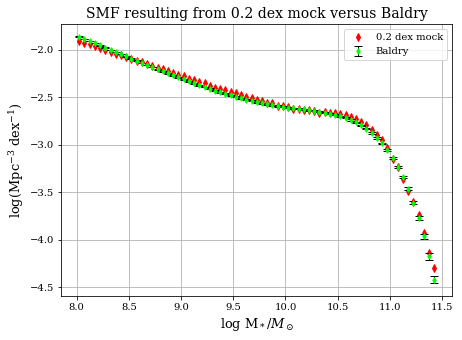

In [187]:
logn2guessar=logn2(p0_Parameters,LOGMSTARMIDBINS)
dlogn2ar=dlogn2(p0_Parameters,LOGMSTARMIDBINS)
fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(1,1,1)
ax.plot(LOGMSTARMIDBINS,logn2guessar,'rd',label='0.2 dex mock',ms=5)
truecol=(0.,255./255.,0./255.)
ax.errorbar(LOGMSTARMIDBINS,logsmftrue,dlogn2ar,fmt='d',mfc=truecol,mec=truecol,capsize=4,ecolor='k', elinewidth=1,ms=4,label='Baldry')
ax.grid()
ax.legend()
ax.set_title('SMF resulting from 0.2 dex mock versus Baldry',fontsize=14)
ax.set_ylabel('log(Mpc$^{-3}$ dex$^{-1}$)',fontsize=13)
ax.set_xlabel('log M$_*/M_\odot$',fontsize=13)
plt.show()

# Manually finding parameters based on $\chi^2_r$

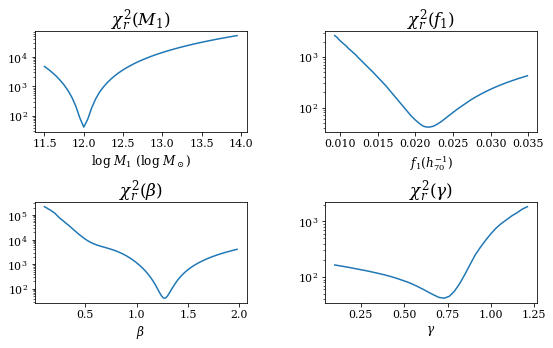

In [147]:
#Calculating the data###############################################################
logm1range=np.arange(8.,14.,0.05)
redchisqroflogm1=np.array([])
for m in logm1range:
    p_redchisqr=[m,f1_0,beta_0,gamma_0]
    resids=logn2(p_redchisqr,LOGMSTARMIDBINS)-logsmftrue
    chisqroflogm1=np.sum((resids/dlogn2ar)**2.)
    redchisqroflogm1=np.append(redchisqroflogm1,chisqroflogm1/(LOGMSTARMIDBINS.size-4.))
    
f1range=np.arange(8.e-3,3.5e-2,0.1e-3)
redchisqroff1=np.array([])
for f in f1range:
    p_redchisqr=[logm1_0,f,beta_0,gamma_0]
    resids=logn2(p_redchisqr,LOGMSTARMIDBINS)-logsmftrue
    chisqroff1=np.sum((resids/dlogn2ar)**2.)
    redchisqroff1=np.append(redchisqroff1,chisqroff1/(LOGMSTARMIDBINS.size-4.))
    
betarange=np.arange(0.1,2.0,0.02)
redchisqrofbeta=np.array([])
for b in betarange:
    p_redchisqr=[logm1_0,f1_0,b,gamma_0]
    resids=logn2(p_redchisqr,LOGMSTARMIDBINS)-logsmftrue
    chisqrofbeta=np.sum((resids/dlogn2ar)**2.)
    redchisqrofbeta=np.append(redchisqrofbeta,chisqrofbeta/(LOGMSTARMIDBINS.size-4.))
    
gammarange=np.arange(0.1,1.5,0.03)
redchisqrofgamma=np.array([])
for g in gammarange:
    p_redchisqr=[logm1_0,f1_0,beta_0,g]
    resids=logn2(p_redchisqr,LOGMSTARMIDBINS)-logsmftrue
    chisqrofgamma=np.sum((resids/dlogn2ar)**2.)
    redchisqrofgamma=np.append(redchisqrofgamma,chisqrofgamma/(LOGMSTARMIDBINS.size-4.))
####################################################################################

#Plotting the results###############################################################
fig=plt.figure(figsize=(9,5))
plt.subplots_adjust(wspace = 0.37,hspace=0.7)
xlabelsize=12
ticklabelsize=11

ax1=fig.add_subplot(2,2,1)
ax1.semilogy(logm1range,redchisqroflogm1)
ax1.set_xlabel('log $M_1$ (log $M_\odot$)',fontsize=xlabelsize)
ax1.set_title('$\chi^2_r(M_1)$',fontsize=17)
ax1.tick_params(axis='both',labelsize=ticklabelsize)

ax2=fig.add_subplot(2,2,2)
ax2.semilogy(f1range,redchisqroff1)
ax2.set_xlabel('$f_1 (h_{70}^{-1})$',fontsize=xlabelsize)
ax2.set_title('$\chi^2_r(f_1)$',fontsize=17)
ax2.tick_params(axis='both',labelsize=ticklabelsize)

ax2=fig.add_subplot(2,2,3)
ax2.semilogy(betarange,redchisqrofbeta)
ax2.set_xlabel('$\\beta$',fontsize=xlabelsize)
ax2.set_title('$\chi^2_r(\\beta)$',fontsize=17)
ax2.tick_params(axis='both',labelsize=ticklabelsize)

ax2=fig.add_subplot(2,2,4)
ax2.semilogy(gammarange,redchisqrofgamma)
ax2.set_xlabel('$\\gamma$',fontsize=xlabelsize)
ax2.set_title('$\chi^2_r(\\gamma)$',fontsize=17)
ax2.tick_params(axis='both',labelsize=ticklabelsize)

plt.show()
####################################################################################

# Testing lmfit

In [136]:
#
dat=np.genfromtxt('GausFitData.txt')
vels=dat[:,0]
stackspec=dat[:,1]
chanwidth=2.574567627
minvel=20.452084230999986; maxvel=-252.452084231
cdelt3=-2.574567627; chanwidth=2.574567627

In [137]:
#
p_gh=Parameters()
p_gh.add('amp',value=np.max(stackspec),vary=True);
p_gh.add('center',value=vels[50],min=np.min(vels),max=np.max(vels));
p_gh.add('sig',value=3*chanwidth,min=chanwidth,max=abs(maxvel-minvel));
p_gh.add('skew',value=0,vary=True,min=None,max=None);
p_gh.add('kurt',value=0,vary=True,min=None,max=None);
 
def gaussfunc_gh(paramsin,x):
    amp=paramsin['amp'].value
    center=paramsin['center'].value
    sig=paramsin['sig'].value
    c1=-np.sqrt(3); c2=-np.sqrt(6); c3=2/np.sqrt(3); c4=np.sqrt(6)/3; c5=np.sqrt(6)/4
    skew=paramsin['skew'].value
    kurt=paramsin['kurt'].value
 
    gaustot_gh=amp*np.exp(-.5*((x-center)/sig)**2)*(1+skew*(c1*((x-center)/sig)+c3*((x-center)/sig)**3)+kurt*(c5+c2*((x-center)/sig)**2+c4*((x-center)/sig)**4))
    return gaustot_gh

In [138]:
#
gausserr_gh = lambda p,x,y: gaussfunc_gh(p,x)-y
gausssingle = lambda a,c,sig,x: a*np.exp(-.5*((x-c)/sig)**2)

In [139]:
fitout_gh=minimize(gausserr_gh,p_gh,args=(vels,stackspec))

In [140]:
#
pars_gh=[fitout_gh.params['amp'].value,
         fitout_gh.params['center'].value,
         fitout_gh.params['sig'].value,
         fitout_gh.params['skew'].value,
         fitout_gh.params['kurt'].value]

In [141]:
#
fit_gh=gaussfunc_gh(fitout_gh.params,vels)
resid_gh=fit_gh-stackspec

In [142]:
#
print('Fitted Parameters (Gaus+Hermite):\nAmp = %.2f , Center = %.2f , Disp = %.2f\nSkew = %.2f , Kurt = %.2f' \
%(pars_gh[0],pars_gh[1],pars_gh[2],pars_gh[3],pars_gh[4]))

Fitted Parameters (Gaus+Hermite):
Amp = 178.66 , Center = -119.13 , Disp = 20.68
Skew = -0.12 , Kurt = -0.03


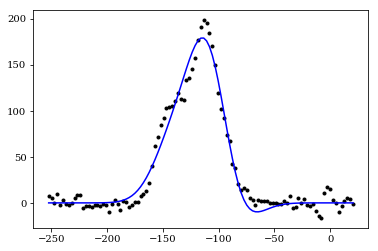

In [143]:
#
plt.plot(vels,stackspec,'k.')
plt.plot(vels,fit_gh,'b')
plt.show()

# Using lmfit with basin hopping

iteration 25
iteration 50
iteration 75
iteration 100
iteration 125
iteration 150
iteration 175
iteration 200

guessed parameters:
logm1
1.200000e+01
f1
2.200000e-02
beta
1.280000e+00
gamma
7.300000e-01
Chi^2: 10532.0
reduced Chi^2: 162.0

fitted parameters:
logm1
1.200114e+01
f1
1.989029e-02
beta
1.241892e+00
gamma
6.826177e-01
Chi^2: 2428.5
reduced Chi^2: 37.4


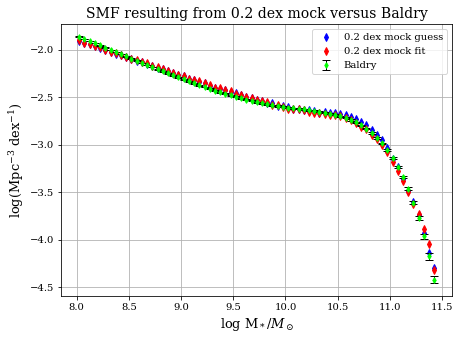

In [388]:
p_chisqr=Parameters()
p_chisqr.add('logm1',value=logm1_0,vary=True,min=11.9,max=12.1)
p_chisqr.add('f1',value=f1_0,vary=True,min=0.017,max=0.025)
p_chisqr.add('beta',value=beta_0,vary=True,min=1.15,max=1.25)
p_chisqr.add('gamma',value=gamma_0,vary=True,min=0.5,max=0.8)

i=0
hudsonfit2=minimize(chifunction2,p_chisqr,args=(LOGMSTARMIDBINS,logsmftrue),method='basinhopping')

print'\nguessed parameters:'
for p in p0_Parameters:
    print p
    print'{0:0.6e}'.format(p0_Parameters[p].value)
chisqrval=np.sum(chifunction2(p0_Parameters,LOGMSTARMIDBINS,logsmftrue))**2.
redchisqrval=chisqrval/(LOGMSTARMIDBINS.size-4.)
print('Chi^2: {0:0.1f}'
     '\nreduced Chi^2: {1:0.1f}').format(chisqrval,redchisqrval)

print'\nfitted parameters:'
for p in hudsonfit2.params:
    print p
    print '{0:0.6e}'.format(hudsonfit2.params[p].value)
chisqrval=np.sum(chifunction2(hudsonfit2.params,LOGMSTARMIDBINS,logsmftrue))**2.
redchisqrval=chisqrval/(LOGMSTARMIDBINS.size-4.)
print('Chi^2: {0:0.1f}'
     '\nreduced Chi^2: {1:0.1f}').format(chisqrval,redchisqrval)

logn2fit=logn2(hudsonfit2.params,LOGMSTARMIDBINS)
fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(1,1,1)
ax.plot(LOGMSTARMIDBINS,logn2guessar,'bd',label='0.2 dex mock guess',ms=5)
ax.plot(LOGMSTARMIDBINS,logn2fit,'rd',label='0.2 dex mock fit',ms=5)
truecol=(0.,255./255.,0./255.)
ax.errorbar(LOGMSTARMIDBINS,logsmftrue,dlogn2ar,fmt='d',mfc=truecol,mec=truecol,capsize=4,ecolor='k', elinewidth=1,ms=4,label='Baldry')
ax.grid()
ax.legend()
ax.set_title('SMF resulting from 0.2 dex mock versus Baldry',fontsize=14)
ax.set_ylabel('log(Mpc$^{-3}$ dex$^{-1}$)',fontsize=13)
ax.set_xlabel('log M$_*/M_\odot$',fontsize=13)
plt.show()